In [2]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
import os
import glob
import pickle
from time import time
from time import strftime
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
#import xarray as xr
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
import astropy.stats.circstats as circstats
    
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
#from ptsa.data.filters import MorletWaveletFilter
from ptsa.data.filters import ButterworthFilter
#from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
from eeg_plotting import plot_trace

In [3]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
data_dir = dirs['data']
epoch_dir = os.path.join(data_dir, 'epoch')
figure_dir = dirs['figs']
sessions = subj_df.groupby('subj_sess').mean().index.tolist()

# Figure out which subjects have dataframes in metadata.
files = glob.glob(os.path.join(data_dir, 'metadata', 'subj_df_*.xlsx'))
subj_df = pd.read_excel(files[0], converters={'chan': str})
for f in files[1:]:
    subj_df = subj_df.append(pd.read_excel(f, converters={'chan': str}))
subj_df = subj_df.loc[subj_df.location!='none']
sessions = sorted(subj_df.groupby('subj_sess').count().index.tolist())

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.



In [4]:
def process_lfp(subj_sess, subj_df, sampling_rate=2000.0, 
                notch_freqs=[60, 120, 180],
                high_pass=None,
                low_pass=None,
                interpolate=False, session_spikes=None, ms_before=2, ms_after=4):
    """Notch filter the raw LFP data and linearly interpolate around spikes."""
    df = subj_df.query("(subj_sess=='{}')".format(subj_sess))
    chans = df.chan.tolist()
    lfp_dat = np.array([np.fromfile(f, dtype='float32') for f in df.raw_lfp_file.tolist()])
    lfp_raw = TimeSeries(lfp_dat, name=subj_sess, 
                         dims=['channel', 'time'],
                         coords={'channel': chans,
                                 'time': np.arange(lfp_dat.shape[1]),
                                 'samplerate': sampling_rate})
    lfp_proc = lfp_raw.copy()
    process_tag = ''
    
    # Notch filter at 60, 120, 180 Hz using a 4th order Butterworth filter.
    for freq in notch_freqs:
        lfp_proc = ButterworthFilter(lfp_proc, freq_range=[freq-2, freq+2], 
                                     filt_type='stop', order=4).filter()
        process_tag += 'notch{}Hz_'.format(freq)
    lfp_proc.name = subj_sess
    
    # Low pass filter the data.
    if low_pass:
        print('Low-pass feature not added yet!')
        #process_tag += 'lowpass{}Hz_'.format(low_pass)
        
    # High pass filter the data.
    if high_pass:
        print('High-pass feature not added yet!')
        #mne.filter.filter_data(np.float64(lfp_proc.data), sfreq=2000, l_freq=58, h_freq=62)
        #process_tag += 'highpass{}Hz_'.format(high_pass)
    
    # Linearly interpolate LFP around spikes, for channels with clusters.
    if interpolate:
        interp_chans = session_spikes.keys()
        for chan in interp_chans:
            interp_mask = session_spikes[chan]['interp_mask']
            keep_inds = np.where(interp_mask==0)[0]
            fill_inds = np.where(interp_mask==1)[0]

            f = interp1d(keep_inds, lfp_proc_dat[lfp_chans.index(chan), keep_inds], 
                         kind='linear', fill_value='extrapolate')
            def apply_interp(arr, inds, f):
                arr[inds] = f(inds)
                return arr
            lfp_proc.data[lfp_chans.index(chan), :] = apply_interp(
                    lfp_proc_dat[lfp_chans.index(chan), :], 
                    fill_inds, 
                    f
                )
        process_tag += 'spikeinterpolation-{}to{}ms_'.format(ms_before, ms_after)
         
    if process_tag:
        process_tag = process_tag[:-1]
    else:
        process_tag = 'same as lfp_raw'
        
    lfp_proc.attrs={'process_tag': process_tag}
        
    return lfp_raw, lfp_proc

In [6]:
subj_sess = sessions[1]
lfp_raw, lfp_proc = process_lfp(subj_sess, subj_df)

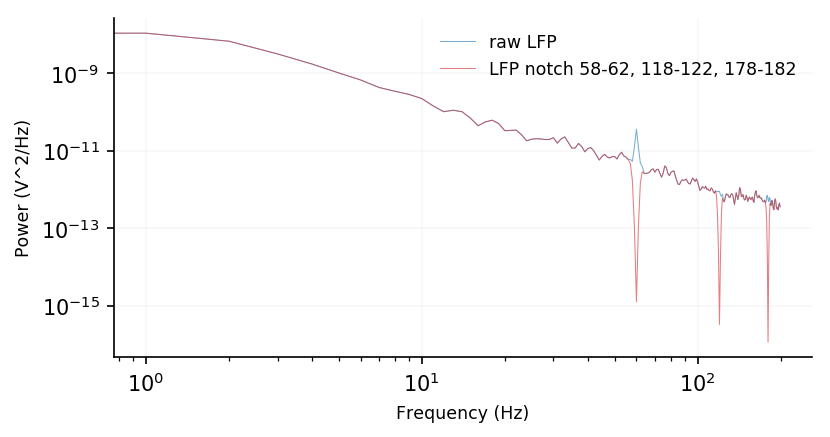

In [12]:
chan = '1'
freq_mean, P_mean = neurodsp.spectral.psd(lfp_raw.sel(channel=chan).data, 2000)
freq_mean2, P_mean2 = neurodsp.spectral.psd(lfp_proc.sel(channel=chan).data, 2000)
plt.figure(figsize=(6,3), dpi=150)
plt.loglog(freq_mean[:200], P_mean[:200], alpha=0.6, linewidth=0.5, label='raw LFP')
plt.loglog(freq_mean2[:200], P_mean2[:200], alpha=0.6, linewidth=0.5, label='LFP notch 58-62, 118-122, 178-182')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.show()

In [13]:
x = np.random.randn(50)
x = x - x.min()
x = (x / x.max()) / 2
x = x * 2 * np.pi
circstats.circmean(x), circstats.circvar(x), circstats.circmoment(x), circstats.rayleightest(x), circstats.vonmisesmle(x)

(1.640250550754853,
 0.2627892456972645,
 (1.640250550754853, 0.7372107543027355),
 1.5793862195847208e-12,
 (1.640250550754853, 2.261015175200627))

In [231]:
# np.degrees(circstats.circmean(np.radians(np.array([51, 67, 40, 109, 31, 358]))))
alphas = [0.05, 0.01, 0.001, 0.0001]
pct_sig = OrderedDict()
for sample_size in [20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]:
    p_vec = []
    for i in range(1000):
        x = np.random.randn(sample_size)
        x = x - x.min()
        x = x / x.max()
        x = x * 2 * np.pi
        p_vec.append(circstats.rayleightest(x))
    p_vec = np.array(p_vec)
    for alpha in alphas:
        pct_sig.setdefault(sample_size, OrderedDict())[alpha] = np.sum(p_vec < alpha) / len(p_vec)

In [34]:
v = lfp_proc.sel(channel=['1'])
freqs = np.logspace(np.log10(1), np.log10(10), num=20)

In [35]:
#manning_analysis.run_morlet??

In [40]:
power, phase = manning_analysis.run_morlet(v, freqs=freqs, width=5, output=['power', 'phase'], 
                                           log_power=True, z_power=True, savedir=False, verbose=True)
power = power.squeeze()
phase = phase.squeeze()

Calculating power and phase.
CPP total time wavelet loop:  4.083216190338135
Log-transforming power values.
Z-scoring power across time, within each frequency.


In [61]:
power

<xarray.TimeSeries 'U369_env1' (frequency: 20, time: 2536279)>
array([[-0.728649, -0.72891 , -0.729172, ...,  0.14356 ,  0.142611,  0.141662],
       [-0.125425, -0.125078, -0.124731, ...,  0.074593,  0.073391,  0.072188],
       [ 0.068632,  0.069269,  0.069905, ..., -0.225756, -0.227361, -0.228967],
       ...,
       [ 1.770012,  1.772038,  1.774032, ..., -0.333778, -0.336138, -0.338518],
       [ 1.706895,  1.709161,  1.711394, ..., -0.091496, -0.094624, -0.097789],
       [ 1.562565,  1.563934,  1.565265, ...,  0.099992,  0.095733,  0.091439]])
Coordinates:
  * frequency   (frequency) float64 1.0 1.129 1.274 1.438 1.624 1.833 2.069 ...
    channel     <U2 '1'
  * time        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    samplerate  float64 2e+03
Attributes:
    morlet_width:  5

In [89]:
g1 = np.where(powerdat[0, :]>1)[0]

oscillations = []
osc_period = int(duration * (power.samplerate.data / freq))
grace_vals = int(osc_period * 0.1)
bad_vals = 0
osc_start = None
osc_length = 0
while i < len(g1):
    osc_start = val
    osc_length = 1
    bad_vals = 0
    else:
        if val > 1:
            osc_length += 1
        else:
            

array([4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862,
       4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873,
       4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884,
       4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895,
       4896, 4897, 4898, 4899, 4900, 4901])

In [90]:
osc_period

6000

In [70]:
osc_mask[0, :].sum() / len(osc_mask[0, :])

0.047715965002273014

In [64]:
start_time = time()

osc_mask = np.zeros(power.shape)
duration = 3
powerdat = power.data
for i, freq in enumerate(power.frequency.data):
    osc_period = int(duration * (power.samplerate.data / freq))
    for t in range(len(power.time) - osc_period):
        if np.all(powerdat[i, t:t+osc_period] > 1):
            osc_mask[i, t:t+osc_period] = 1
    break
print('Done in {:.0f} secs'.format(time() - start_time))

Done in 19 secs


In [147]:
subj_sess = sessions[0]
subj_df_, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
            subj_sess, subj_df, subj_df_file, overwrite=False
        )

In [ ]:
neurodsp.filter(lfp_proc60.data[0, :], Fs=2000, pass_type='highpass', fc=0.1)

(<Figure size 1800x600 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ba3cee7a278>],
       dtype=object))

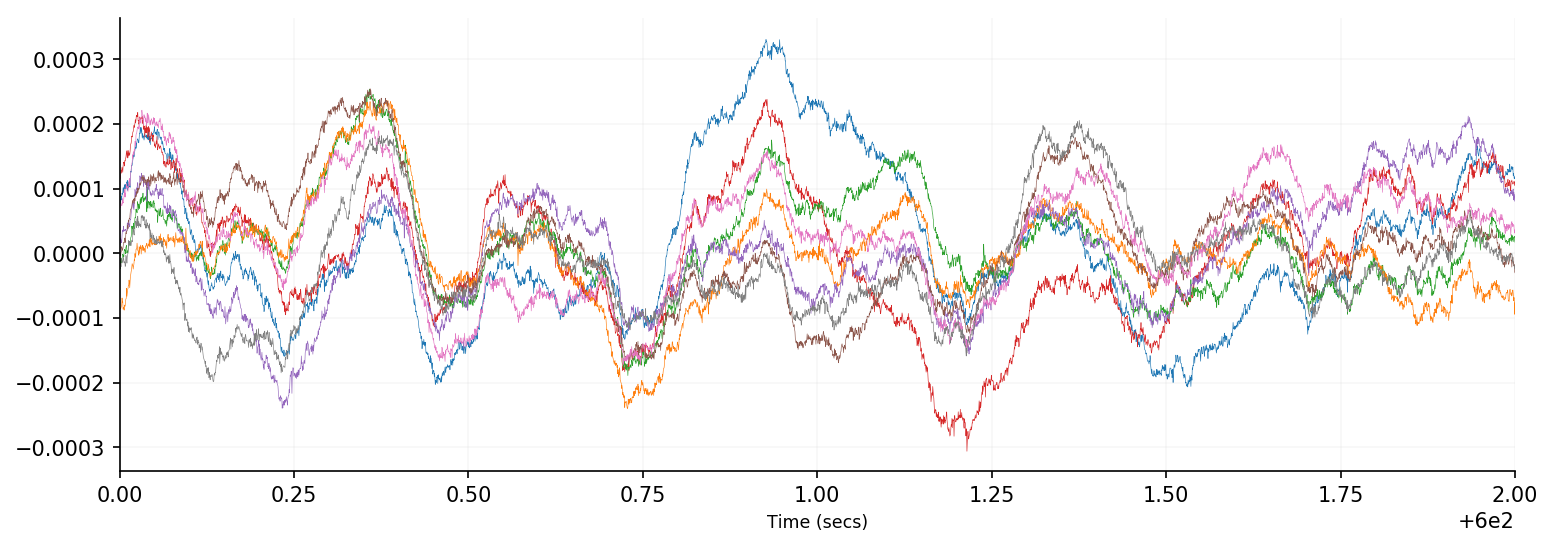

In [15]:
plot_trace(lfp_proc.sel(channel=lfp_proc.channel.data[0:8]), start=600, duration=2, x_units='secs')

Setting up band-pass filter from 58 - 62 Hz
l_trans_bandwidth chosen to be 14.5 Hz
h_trans_bandwidth chosen to be 15.5 Hz
Filter length of 455 samples (0.228 sec) selected
Setting up band-pass filter from 58 - 62 Hz
l_trans_bandwidth chosen to be 14.5 Hz
h_trans_bandwidth chosen to be 15.5 Hz
Filter length of 455 samples (0.228 sec) selected
Setting up band-pass filter from 58 - 62 Hz
l_trans_bandwidth chosen to be 14.5 Hz
h_trans_bandwidth chosen to be 15.5 Hz
Filter length of 455 samples (0.228 sec) selected


(<Figure size 1800x600 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ae718d44be0>],
       dtype=object))

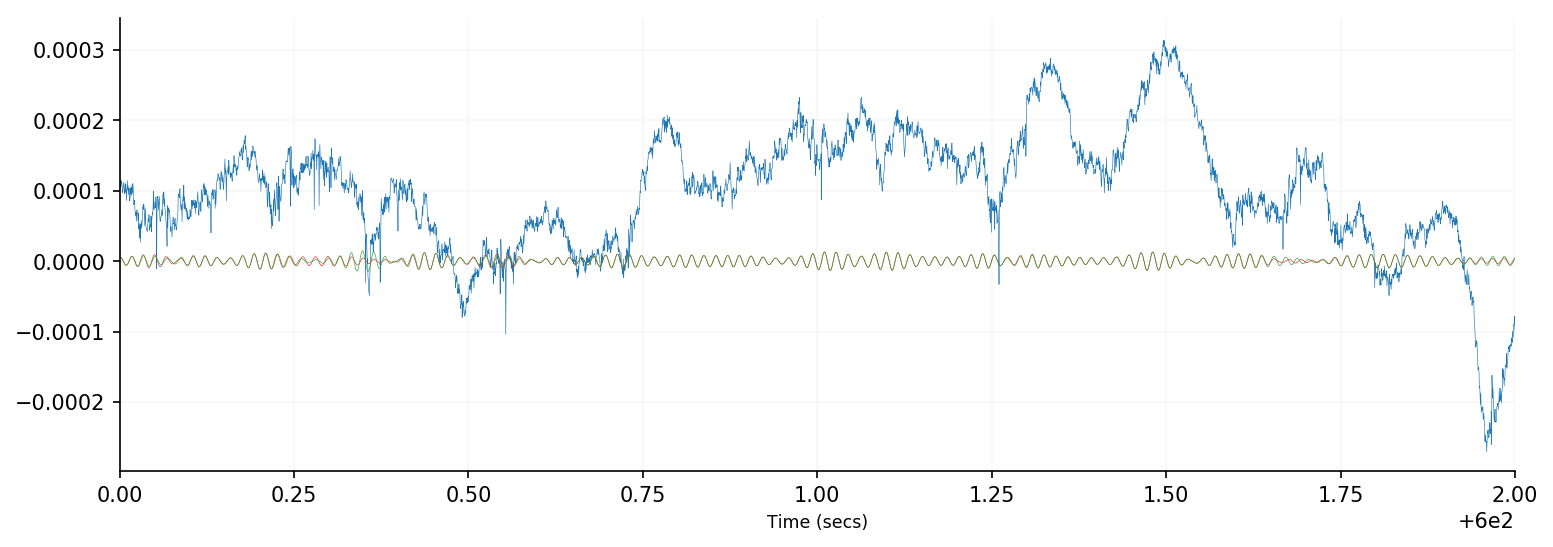

In [94]:
x = mne.filter.filter_data(np.float64(lfp_raw.sel(channel=lfp_proc.channel.data[:1]).data), sfreq=2000, l_freq=58, h_freq=62)
x2 = mne.filter.filter_data(lfp_proc.sel(channel=lfp_proc.channel.data[:1]).data, sfreq=2000, l_freq=58, h_freq=62)
x3 = mne.filter.filter_data(lfp_proc2.sel(channel=lfp_proc.channel.data[:1]).data, sfreq=2000, l_freq=58, h_freq=62)
plot_trace(np.vstack((lfp_proc2.sel(channel=lfp_proc.channel.data[:1]), x2, x3)), start=600, duration=2, x_units='secs')

In [73]:
sessions

NameError: name 'sessions' is not defined

In [150]:
def preprocess_sessions_parallel(subj_sess):
    """Wrapper function to process LFP and spike data through epoching."""
    import os
    import sys
    sys.path.append('/home1/dscho/code/projects/manning_replication')
    from time import strftime
    import logging
    import numpy as np
    import pandas as pd
    import manning_analysis
    
    ## Setup.
    # ----------------------------------
    
    # Read the subjects' DataFrame.
    subj_df_file = '/data3/scratch/dscho/frLfp/data/subj_df.xlsx'
    subj_df = pd.read_excel(subj_df_file)
    
    # Select frequencies to get power and phase estimates for.
    freq_low = 2
    freq_high = 150
    freq_steps = 50
    
    ## Run.
    # ----------------------------------
    
    # Preprocess spikes and LFP.
    if True:
        subj_df, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
            subj_sess, 
            subj_df, 
            subj_df_file, 
            overwrite=False
        )    
    
    # Run wavelets over each channel.
    if False:
        freqs = np.logspace(np.log10(freq_low), np.log10(freq_high), freq_steps, base=10)
        for chan in lfp_proc.channel.data:
            power, phase = manning_analysis.run_morlet(
                lfp_proc.sel(channel=[chan]), 
                width=5, 
                freqs=freqs, 
                log_power=False, 
                z_power=False, 
                overwrite=False
            )
    
    # Epoch each channel.
    if False:
        epoch_fr, epoch_power, epoch_band_power = manning_analysis.epoch_fr_power(
            subj_sess, 
            lfp_proc, 
            fr_df, 
            chan_to_clus, 
            chans=lfp_proc.channel.data,
            log_power=True,
            z_power='acrossfreq',
            freq_params={'low': freq_low, 'high': freq_high, 'num': freq_steps},
            epoch_size=1000,
            epoch_cut=3,
            power_file_suffix='_width5_{}-{}Hz-{}log10steps'.format(freq_low, freq_high, freq_steps),
            load_existing=True,
            save_files=True
        )
    
    return None

In [42]:
print('Running preprocessing for {} sessions.'.format(len(sessions)))
print('Starting clusters.')
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(sessions), 
                  cores_per_job=1, extra_params={'mem':32}) as view: 
    output = view.map(preprocess_sessions_parallel, sessions)

In [43]:
## Preprocess selected recording sessions, and save the raw LFP, processed LFP,
# spike data, and subjects' DataFrame.
start = time()

# Read the subjects' DataFrame.
subj_df_file = '/data3/scratch/dscho/frLfp/data/subj_df.xlsx'
subj_df = pd.read_excel(subj_df_file, converters={'chan': str})
subj_df.drop(subj_df.query("(subj=='U385') & (chan==['57', '58', '59', '60', '61', '62', '63', '64'])").index.tolist(), inplace=True)

for subj_sess in sessions[10:]:
    start_lap = time()
    # Get processed LFP and spike data.
    subj_df_, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
                subj_sess, subj_df, subj_df_file, overwrite=True
            )
    print('{} done in {:.0f} secs.'.format(subj_sess, time() - start_lap))

print('\nDone in {:.0f} secs.'.format(time() - start))

U373_ses2 done in 86 secs.
U373_ses3 done in 85 secs.
U374_ses1 done in 135 secs.
U374_ses2 done in 118 secs.
U379_ses1 done in 119 secs.
U380_ses1a done in 122 secs.
U380_ses2 done in 122 secs.
U380_ses3 done in 94 secs.
U381_ses1 done in 121 secs.
U381_ses2 done in 88 secs.
U381_ses3 done in 111 secs.
U384_ses1 done in 163 secs.
U384_ses2 done in 149 secs.
U384_ses3 done in 77 secs.
U386_ses1 done in 107 secs.
U386_ses2 done in 83 secs.
U387_ses1 done in 116 secs.
U387_ses2 done in 70 secs.
U387_ses3 done in 84 secs.
U390_ses1 done in 55 secs.
U390_ses2 done in 37 secs.
U390_ses3 done in 46 secs.
U390_ses4 done in 63 secs.
U392_ses1 done in 71 secs.
U393_ses2 done in 161 secs.
U394_ses1 done in 74 secs.
U394_ses3 done in 44 secs.
U395_ses1 done in 80 secs.
U395_ses2 done in 98 secs.
U395_ses3 done in 74 secs.
U396_ses2 done in 58 secs.
U396_ses3 done in 61 secs.

Done in 2976 secs.


In [82]:
## Preprocess selected recording sessions, and save the raw LFP, processed LFP,
# spike data, and subjects' DataFrame.
start = time()

# Read the subjects' DataFrame.
subj_df_file = '/data3/scratch/dscho/frLfp/data/subj_df.xlsx'
subj_df = pd.read_excel(subj_df_file, converters={'chan': str})
subj_df.drop(subj_df.query("(subj=='U385') & (chan==['57', '58', '59', '60', '61', '62', '63', '64'])").index.tolist(), inplace=True)

for subj_sess in ['U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4']:
    start_lap = time()
    # Get processed LFP and spike data.
    subj_df_, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
                subj_sess, subj_df, subj_df_file, overwrite=True
            )
    print('{} done in {:.0f} secs.'.format(subj_sess, time() - start_lap))

print('\nDone in {:.0f} secs.'.format(time() - start))

U385_ses1 done in 113 secs.
U385_ses2 done in 78 secs.
U385_ses3 done in 76 secs.
U385_ses4 done in 82 secs.

Done in 350 secs.


In [93]:
with open(os.path.join(data_dir, 'other', 'process_chans.pkl'), 'rb') as f:
    process_chans = pickle.load(f)     

In [101]:
TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))

<xarray.TimeSeries 'U385_ses4' (channel: 56, time: 2354357)>
array([[-3.928441e-05, -3.542499e-05, -4.233651e-05, ...,  1.654487e-04,
         1.589435e-04,  1.601971e-04],
       [ 2.058205e-04,  1.982126e-04,  2.040142e-04, ...,  1.502652e-04,
         1.663213e-04,  1.431403e-04],
       [-4.162404e-05, -2.742473e-05, -2.859817e-05, ...,  2.377524e-04,
         2.377672e-04,  2.235617e-04],
       ...,
       [ 1.249500e-04,  1.288618e-04,  1.328963e-04, ...,  2.034824e-04,
         2.070003e-04,  1.988584e-04],
       [ 7.645004e-05,  8.216192e-05,  7.736947e-05, ...,  1.552625e-04,
         1.456321e-04,  1.320908e-04],
       [ 4.127032e-05,  4.407090e-05,  4.135245e-05, ...,  1.209690e-04,
         1.228312e-04,  1.203823e-04]])
Coordinates:
  * channel     (channel) <U2 '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' ...
  * time        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    samplerate  float64 2e+03

In [ ]:
# PROCESS ALL CHANNELS!
freqs = np.logspace(np.log10(2), np.log10(200), 50, base=10)
for subj_sess in sorted(process_chans.keys()):
    lfp_proc = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_notch-filtered_spikes-interpolated.hdf'.format(subj_sess)))
    for chan in process_chans[subj_sess]:
        power, phase = manning_analysis.run_morlet(lfp_proc.sel(channel=[chan]), 
                                                   freqs=freqs, 
                                                   width=5, 
                                                   log_power=False, 
                                                   z_power=False, 
                                                   overwrite=False)

CPP total time wavelet loop:  16.806623458862305
CPP total time wavelet loop:  18.53887629508972
CPP total time wavelet loop:  18.796570301055908
CPP total time wavelet loop:  17.004873037338257
CPP total time wavelet loop:  17.501620531082153
CPP total time wavelet loop:  18.439037322998047
CPP total time wavelet loop:  17.667373418807983


In [ ]:
# Figure out which subjects have power files saved in ~data/lfp/morlet
files = glob.glob(os.path.join(data_dir, 'lfp', '*notch-filtered_spikes-interpolated.hdf'))
lfp_files = OrderedDict()
for f in sorted(files):
    subj_sess = os.path.basename(f)[:os.path.basename(f).index('_notch')]
    lfp_files[subj_sess] = f
sessions = list(lfp_files.keys())
print('{} sessions with processed LFP'.format(len(sessions)))

In [148]:
files = sorted(glob.glob('/data3/scratch/dscho/frLfp/data/metadata/*.xlsx'))
df = pd.read_excel(files[0])
for f in files[1:]:
    df = df.append(pd.read_excel(f))
df.head(5)

,subj_sess,subj,sess,chan,location,sess_duration,raw_lfp_file,spike_times_file,input_files_exist,process_chan,n_clusters,proc_lfp_file,session_spikes_file
0,U367_env2,U367,env2,1,RTG,1494.7935,/data/continuous/U367/env2/lfp/chan.001,/data3/scratch/dscho/frLfp/data/raw/U367/env2/...,1,1,2,/data3/scratch/dscho/frLfp/data/lfp/U367_env2_...,/data3/scratch/dscho/frLfp/data/spikes/U367_en...
1,U367_env2,U367,env2,2,RTG,1494.7935,/data/continuous/U367/env2/lfp/chan.002,/data3/scratch/dscho/frLfp/data/raw/U367/env2/...,1,1,2,/data3/scratch/dscho/frLfp/data/lfp/U367_env2_...,/data3/scratch/dscho/frLfp/data/spikes/U367_en...
2,U367_env2,U367,env2,3,RTG,1494.7935,/data/continuous/U367/env2/lfp/chan.003,/data3/scratch/dscho/frLfp/data/raw/U367/env2/...,1,1,2,/data3/scratch/dscho/frLfp/data/lfp/U367_env2_...,/data3/scratch/dscho/frLfp/data/spikes/U367_en...
3,U367_env2,U367,env2,4,RTG,1494.7935,/data/continuous/U367/env2/lfp/chan.004,/data3/scratch/dscho/frLfp/data/raw/U367/env2/...,1,1,3,/data3/scratch/dscho/frLfp/data/lfp/U367_env2_...,/data3/scratch/dscho/frLfp/data/spikes/U367_en...
4,U367_env2,U367,env2,5,RTG,1494.7935,/data/continuous/U367/env2/lfp/chan.005,/data3/scratch/dscho/frLfp/data/raw/U367/env2/...,1,1,2,/data3/scratch/dscho/frLfp/data/lfp/U367_env2_...,/data3/scratch/dscho/frLfp/data/spikes/U367_en...


In [4]:
# Function to parallelize wavelet analyses across channels
# for a given session.
def run_morlet(timeseries, 
               freqs=None, 
               width=5, 
               log_power=False, 
               z_power=False, 
               z_power_acrossfreq=False, 
               overwrite=False,
               savedir='/data3/scratch/dscho/frLfp/data/lfp/morlet'):
    """Apply Morlet wavelet transform to a timeseries to calculate
    power and phase spectra for one or more frequencies.
    
    Serves as a wrapper for PTSA's MorletWaveletFilter. Can log 
    transform and/or Z-score power across time and can save the 
    returned power and phase timeseries objects as hdf5 files.
    
    Parameters
    ----------
    timeseries : ptsa.data.timeseries.TimeSeries
        The timeseries data to be transformed.
    freqs : numpy.ndarray or list
        A list of frequencies to apply wavelet decomposition over.
    width : int
        Number of waves for each frequency.
    log_power : bool
        If True, power values are log10 transformed.
    z_power : bool
        If True, power values are Z-scored across the time dimension.
        Requires timeseries to have a dimension called 'time'.
        z_power and z_power_acrossfreq can't both be True.
    z_power_acrossfreq : bool
        If True, power values are Z-scored across frequencies and
        time for a given channel. Requires timeseries to have
        a dimension called 'time'. z_power and z_power_acrossfreq 
        can't both be True.
    overwrite : bool
        If True, existing files will be overwritten.
    savedir : str
        Directory where the output files (power and phase timeseries
        objects saved in hdf5 format) will be saved. No files are
        saved if savedir is None.
    
    Returns
    -------
    power : ptsa.data.timeseries.TimeSeries
        Power spectra with optional log and/or Z transforms applied.
        Has the same shape as timeseries. 
    phase : ptsa.data.timeseries.TimeSeries
        Phase spectra with optional log and/or Z transforms applied.
        Has the same shape as timeseries.
    """
    import os
    import numpy as np
    from ptsa.data.filters import MorletWaveletFilter
    from ptsa.data.TimeSeriesX import TimeSeries
    
    assert timeseries.dims == ('channel', 'time')
    assert not np.all([z_power, z_power_acrossfreq])
    
    if freqs is None:
        freqs = np.logspace(np.log10(2), np.log10(200), 50, base=10)
    
    fstr = ('_width{}_{:.0f}-{:.0f}Hz-{}log10steps'
            .format(width, min(freqs), max(freqs), len(freqs)))
    
    powfstr = ''
    if log_power:
        powfstr += '_log'
    if z_power:
        powfstr += '_Z-withinfreq'
    if z_power_acrossfreq:
        powfstr += '_Z-acrossfreq'
    
    # If power and phase already exist and aren't supposed to be overwritten,
    # load them from memory and return.
    if savedir:
        fname = ('{}_ch{}_power{}{}.hdf'
                 .format(timeseries.name, timeseries.channel.data[0], fstr, powfstr))
        power_file = os.path.join(savedir, fname)
        fname = ('{}_ch{}_phase{}.hdf'
                 .format(timeseries.name,timeseries.channel.data[0], fstr))
        phase_file = os.path.join(savedir, fname)
        if os.path.exists(power_file) and os.path.exists(phase_file) and not overwrite:
            return None
    
    # Get power and phase.
    power, phase = MorletWaveletFilter(timeseries,
                                       freqs=freqs,
                                       width=width,
                                       output=['power', 'phase']).filter()
                                       
    power = TimeSeries(power.data, dims=['frequency', 'channel', 'time'], 
                       name=timeseries.name, 
                       coords={'frequency': power.frequency.data,
                               'channel': power.channel.data,
                               'time': power.time.data,
                               'samplerate': power.samplerate.data},
                       attrs={'morlet_width': width})

    phase = TimeSeries(phase.data, dims=['frequency', 'channel', 'time'], 
                       name=timeseries.name, 
                       coords={'frequency': phase.frequency.data,
                               'channel': phase.channel.data,
                               'time': phase.time.data,
                               'samplerate': phase.samplerate.data},
                       attrs={'morlet_width': width})  
    
    # Log transform every power value.
    if log_power:
        power.data = np.log10(power)
        
    # Z-score power over time for each channel, frequency vector.
    if z_power:
        power.data = (power - power.mean(dim='time')) / power.std(dim='time')
        
    # Z-score power across frequencies and time, for each channel
    if z_power_acrossfreq:
        power.data = ((power - power.mean(dim=['frequency', 'time'])) 
                      / power.std(dim=['frequency', 'time']))
    
    # Return log-transformed power and phase.
    if savedir:
        power.to_hdf(power_file)
        phase.to_hdf(phase_file)
    
    return None

In [8]:
# Parellelize wavelet analaysis across channels in the session!

# Use Morlet wavelets to estimate power and phase at each timepoint
# in the session, for 50 log-spaced frequencies from 2 to 150 Hz.
morlet_dir = os.path.join(dirs['data'], 'lfp', 'morlet')
dat = [chan.expand_dims('channel', axis=0) for chan in lfp_proc]

print('Starting clusters')
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(lfp_proc.channel), 
                  cores_per_job=1, extra_params={'mem':16}) as view: 
    output = view.map(run_morlet, dat)

In [ ]:
## Divide power and spike data for each channel into 500ms epochs.
#chans = sorted(set(fr_df.loc[fr_df.location=='RPH', 'chan'])) # 17-24; 14 units, mean FR 0.03-8.23Hz, each channel has at least 1 unit

epoch_fr, epoch_power, epoch_band_power = manning_analysis.epoch_fr_power(subj_sess, lfp_proc, fr_df, chan_to_clus, 
                                                                          chans=lfp_proc.channel.data,
                                                                          log_power=True,
                                                                          z_power='acrossfreq',
                                                                          freq_params={'low': 2, 'high': 200, 'num': 50},
                                                                          epoch_size=1000,
                                                                          epoch_cut=3,
                                                                          power_file_suffix='_width5_2-200Hz-50log10steps',
                                                                          load_existing=False, 
                                                                          save_files=True)
#epoch_power = epoch_power.squeeze()
#epoch_band_power = epoch_band_power.squeeze()

In [197]:
## Preprocess selected recording sessions, and save the raw LFP, processed LFP,
# spike data, and subjects' DataFrame.
start = time()
for subj_sess in ['U369_env2', 'U379_ses1', 'U380_ses1a', 'U381_ses1', 'U384_ses3',
                  'U390_ses1', 'U394_ses3', 'U395_ses2', 'U395_ses3']:
    print(subj_sess)
    subj_df_, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
            subj_sess, subj_df, subj_df_file, overwrite=False
        )
    
    epoch_fr, epoch_power, epoch_band_power = manning_analysis.epoch_fr_power(subj_sess, lfp_proc, fr_df, chan_to_clus, 
                                                                              chans=lfp_proc.channel.data,
                                                                              log_power=True,
                                                                              z_power='acrossfreq',
                                                                              freq_params={'low': 2, 'high': 200, 'num': 50},
                                                                              epoch_size=1000,
                                                                              epoch_cut=3,
                                                                              power_file_suffix='_width5_2-200Hz-50log10steps',
                                                                              load_existing=False, 
                                                                              save_files=True)
print('Done in {:.0f} secs.'.format(time() - start))

U369_env2
U379_ses1


TypeError: Object of type 'int64' is not JSON serializable

In [5]:
# Load all epoch data and get channel/cluster mappings.
epoch_dat = {}
for subj_sess in sessions:
    fr_file = os.path.join(epoch_dir, '{}_fr_epoch-2Hz-cut3.hdf'.format(subj_sess))
    power_file = os.path.join(epoch_dir, '{}_power_width5_2-200Hz-50log10steps_epoch-2Hz-cut3_log10_Z-acrossfreq.hdf'.format(subj_sess))
    bands_file = os.path.join(epoch_dir, '{}_power_width5_2-200Hz-50log10steps_epoch-2Hz-cut3_log10_Z-acrossfreq_freqbands.hdf'.format(subj_sess))
    files_exist = (os.path.exists(fr_file) and os.path.exists(power_file) and os.path.exists(bands_file))
    if files_exist:
        epoch_dat[subj_sess] = {'fr': TimeSeries.from_hdf(fr_file),
                                'power': TimeSeries.from_hdf(power_file),
                                'bands': TimeSeries.from_hdf(bands_file)}
print('Loaded epoch data for {} sessions.'.format(len(epoch_dat)))

Loaded epoch data for 10 sessions.


In [395]:
# Correlate epoched firing rate for each cluster in the
# session to narrowband and broadband power measures.
band_pcorrs = []
band_scorrs = []
for clus in clus_to_chan.keys():
    chan = clus_to_chan[clus]
    roi = fr_df.loc[fr_df.clus==clus, 'location'].iat[0]
    prow = [clus, chan, roi]
    srow = [clus, chan, roi]
    for band in epoch_band_power.freq.data:
        prow.append(stats.pearsonr(epoch_band_power.sel(channel=chan, freq=band),
                                   epoch_fr.sel(cluster=clus))[0])
        srow.append(stats.spearmanr(epoch_band_power.sel(channel=chan, freq=band),
                                    epoch_fr.sel(cluster=clus))[0])
    band_pcorrs.append(prow)
    band_scorrs.append(srow)
col_names = ['clus', 'chan', 'location'] + list(epoch_band_power.freq.data)
band_pcorrs = pd.DataFrame(band_pcorrs, columns=col_names)
band_scorrs = pd.DataFrame(band_scorrs, columns=col_names)

In [498]:
for band in epoch_band_power.freq.data:
    print('{}: {}'.format(band, stats.pearsonr(epoch_band_power.sel(freq=band).data.flatten(),
                                               wepoch_band_power.sel(freq=band).data.flatten())))

delta: (0.8952997274407568, 0.0)
theta: (0.8449229029800056, 0.0)
alpha: (0.7384019851939378, 0.0)
beta: (0.5998730066191619, 0.0)
gamma: (0.5613581524699223, 0.0)
intercept: (0.8740696603307536, 0.0)
bband_tilt: (0.827408774791302, 0.0)
bband_power: (0.863756640351544, 0.0)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b5459c7f860>,
      dtype=object)

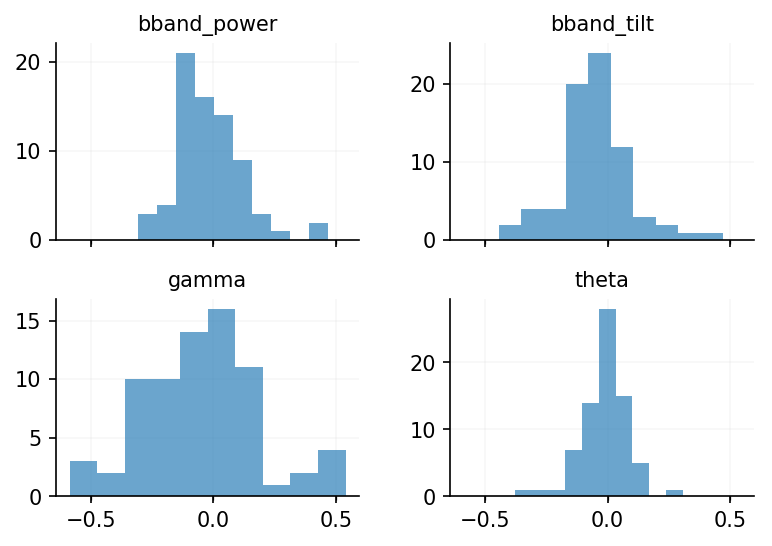

In [484]:
band_pcorrs.loc[:, ['theta', 'gamma', 'bband_tilt', 'bband_power']].hist(alpha=0.66, sharex=True)

#band_pcorrs.bband_tilt.hist(alpha=0.5, label='bband tilt')
#band_pcorrs.bband_power.hist(alpha=0.5, label='bband power')

In [507]:
# Correlate epoched firing rate for each cluster in the
# session to narrowband and broadband power measures.
wband_pcorrs = []
wband_scorrs = []
for clus in clus_to_chan.keys():
    chan = clus_to_chan[clus]
    roi = fr_df.loc[fr_df.clus==clus, 'location'].iat[0]
    prow = [clus, chan, roi]
    srow = [clus, chan, roi]
    for band in wepoch_band_power.freq.data:
        prow.append(stats.pearsonr(wepoch_band_power.sel(channel=chan, freq=band),
                                   epoch_fr.sel(cluster=clus))[0])
        srow.append(stats.spearmanr(wepoch_band_power.sel(channel=chan, freq=band),
                                    epoch_fr.sel(cluster=clus))[0])
    wband_pcorrs.append(prow)
    wband_scorrs.append(srow)
col_names = ['clus', 'chan', 'location'] + list(wepoch_band_power.freq.data)
wband_pcorrs = pd.DataFrame(wband_pcorrs, columns=col_names)
wband_scorrs = pd.DataFrame(wband_scorrs, columns=col_names)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b545a4df940>,
      dtype=object)

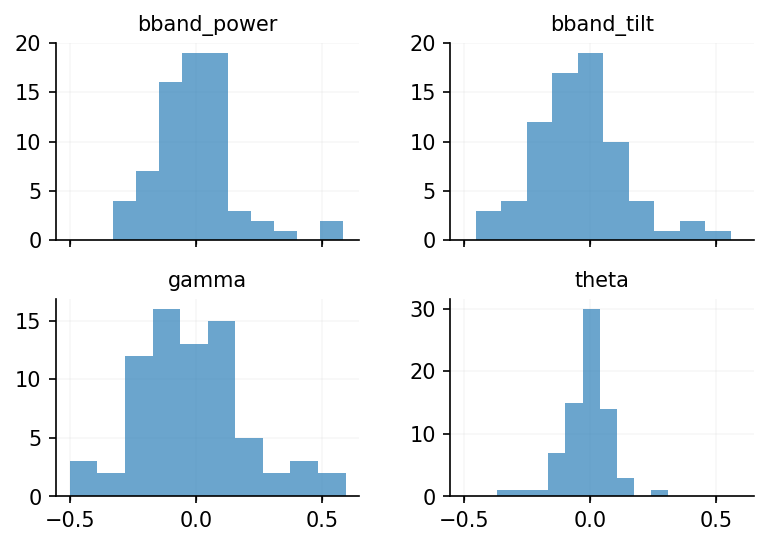

In [508]:
wband_pcorrs.loc[:, ['theta', 'gamma', 'bband_tilt', 'bband_power']].hist(alpha=0.66, sharex=True)
#band_pcorrs.loc[:, ['theta', 'gamma', 'bband_tilt', 'bband_power']].hist(alpha=0.66, sharex=True)
#band_pcorrs.bband_tilt.hist(alpha=0.5, label='bband tilt')
#band_pcorrs.bband_power.hist(alpha=0.5, label='bband power')

In [598]:
chans[np.random.randint(0, nclus)]

'4'

In [614]:
# Let's do some random pairing of clusters and LFP channels
# and look at the distribution of FR vs band correlations

# Correlate epoched firing rate for each cluster in the
# session to narrowband and broadband power measures.
n_samples = 100
rband_pcorrs = []
clusters = list(clus_to_chan.keys())
chans = list(clus_to_chan.values())
nclus = len(clus_to_chan)
start = time()
for sample in range(n_samples):
    for datapoint in range(len(epoch_fr.cluster)):
        clus = clusters[np.random.randint(0, nclus)]
        chan = chans[np.random.randint(0, nclus)]
        prow = [sample, clus, chan]
        for band in wepoch_band_power.freq.data:
            prow.append(stats.pearsonr(epoch_band_power.sel(channel=chan, freq=band),
                                       epoch_fr.sel(cluster=clus))[0])
        rband_pcorrs.append(prow)
col_names = ['sample', 'clus', 'chan'] + list(wepoch_band_power.freq.data)
rband_pcorrs = pd.DataFrame(rband_pcorrs, columns=col_names)
print('Done in {:.0f} secs.'.format(time() - start))

Done in 76 secs.


In [612]:
band_pcorrs[['theta', 'gamma', 'bband_tilt', 'bband_power']].mean()

theta         -0.011559
gamma         -0.044348
bband_tilt    -0.047739
bband_power   -0.018744
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b545a165240>,
      dtype=object)

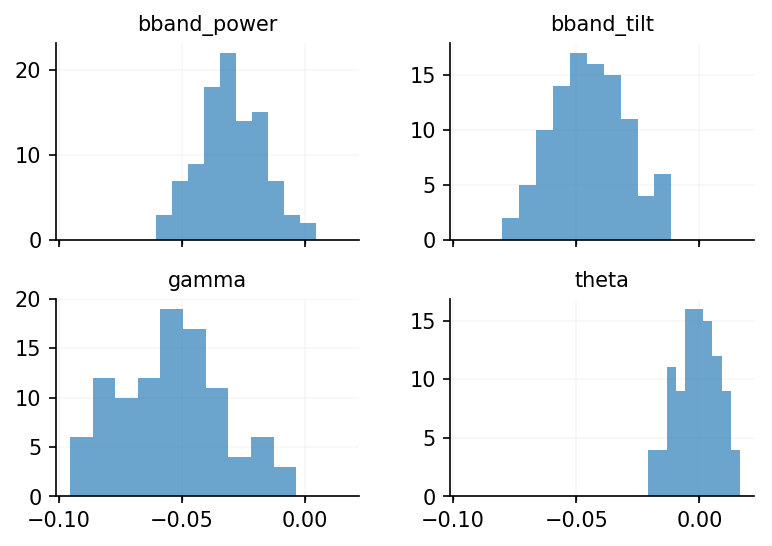

In [615]:
# Estimate of the mean FR/band correlation for random unit/channel pairings,
# taken from 100 samples of the same size as the number of units for U367-env2
rband_pcorrs.groupby('sample').mean().loc[:, ['theta', 'gamma', 'bband_tilt', 'bband_power']].hist(alpha=0.66, sharex=True)

In [617]:
# Let's make something like Fig 7

## Plots

In [11]:
# Load power and phase for an example channel.
chan = '1'
power = TimeSeries.from_hdf(os.path.join(morlet_dir, 'U367_env2_ch{}_power_width5_2-200Hz-50log10steps.hdf'.format(chan)))
phase = TimeSeries.from_hdf(os.path.join(morlet_dir, 'U367_env2_ch{}_phase_width5_2-200Hz-50log10steps.hdf'.format(chan)))
power = power.squeeze()
phase = phase.squeeze()

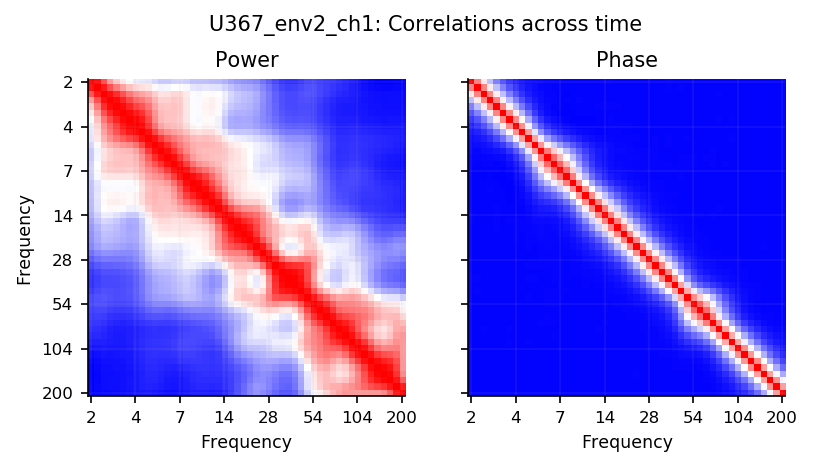

In [92]:
# Plot correlation matrices for power and phase across
# timepoints, for a given channel.
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6, 6), dpi=150)

ax[0].imshow(np.corrcoef(power), cmap='bwr')
ax[0].set_xticks(np.arange(0, 50, 7))
ax[0].set_yticks(np.arange(0, 50, 7))
ax[0].set_xticklabels([int(round(x, 0)) for x in power.frequency.data[np.arange(0, 50, 7)]], fontsize=8)
ax[0].set_yticklabels([int(round(x, 0)) for x in power.frequency.data[np.arange(0, 50, 7)]], fontsize=8)
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Power', fontsize=10)

ax[1].imshow(np.corrcoef(phase), cmap='bwr')
ax[1].set_xticks(np.arange(0, 50, 7))
ax[1].set_yticks(np.arange(0, 50, 7))
ax[1].set_xticklabels([int(round(x, 0)) for x in power.frequency.data[np.arange(0, 50, 7)]], fontsize=8)
ax[1].set_yticklabels([int(round(x, 0)) for x in power.frequency.data[np.arange(0, 50, 7)]], fontsize=8)
ax[1].set_xlabel('Frequency')
ax[1].set_title('Phase', fontsize=10)

fig.suptitle('{}_ch{}: Correlations across time'.format(subj_sess, chan), y=0.75, fontsize=10)
f = os.path.join(figure_dir, 'power_phase_corrmats_over_time_{}_ch{}.png'.format(subj_sess, chan))
fig.savefig(f)

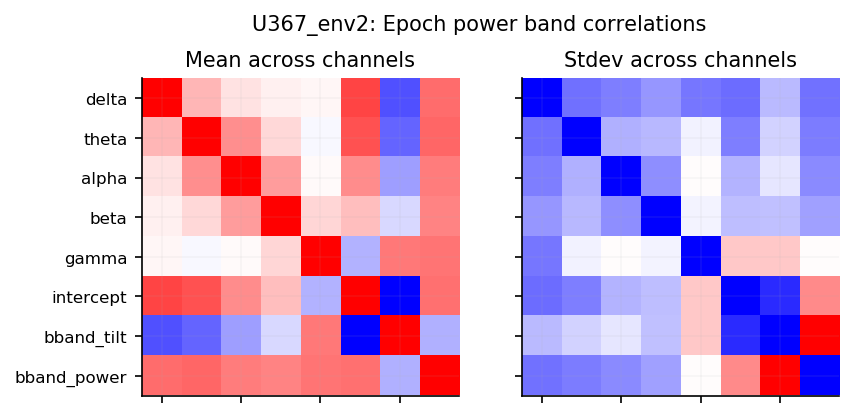

In [445]:
# How correlated are the epoched power measures with each other?
band_corrms = []
for chan in epoch_band_power.channel.data:
    dat = epoch_band_power.sel(channel=chan).T.data # freq x epoch
    band_corrms.append(np.corrcoef(dat))
band_corrms = np.array(band_corrms) # chan x freq x freq

# Plot correlation matrices for band power measures vs each other.
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6, 6), dpi=150)

ax[0].imshow(np.mean(band_corrms, axis=0), cmap='bwr')
ax[0].set_yticks(np.arange(len(epoch_band_power.freq.data)))
ax[0].set_xticklabels([''] * len(epoch_band_power.freq.data))
ax[0].set_yticklabels(epoch_band_power.freq.data, fontsize=8)
ax[0].set_title('Mean across channels', fontsize=10)

ax[1].imshow(np.std(band_corrms, axis=0), cmap='bwr')
ax[1].set_xticklabels([''] * len(epoch_band_power.freq.data))
ax[1].set_title('Stdev across channels', fontsize=10)

fig.suptitle('{}: Epoch power band correlations'.format(subj_sess), y=0.75, fontsize=10)
f = os.path.join(figure_dir, 'band_power_corrmats_{}.png'.format(subj_sess))
#fig.savefig(f)

In [17]:
# Z-score processed LFP across time, for each channel.
lfp_proc_z = (lfp_proc - lfp_proc.mean(dim='time')) / lfp_proc.std(dim='time')

# Bandpass filter the processed LFP data within each frequency band. 
lfp_filt = OrderedDict()

lfp_filt['delta'] = mne.filter.filter_data(lfp_proc.sel(channel='1').data, sfreq=2000, l_freq=2, h_freq=4)
lfp_filt['delta_z'] = (lfp_filt['delta'] - np.mean(lfp_filt['delta'])) / np.std(lfp_filt['delta'])

lfp_filt['theta'] = mne.filter.filter_data(lfp_proc.sel(channel='1').data, sfreq=2000, l_freq=4, h_freq=8)
lfp_filt['theta_z'] = (lfp_filt['theta'] - np.mean(lfp_filt['theta'])) / np.std(lfp_filt['theta'])

lfp_filt['alpha'] = mne.filter.filter_data(lfp_proc.sel(channel='1').data, sfreq=2000, l_freq=8, h_freq=12)
lfp_filt['alpha_z'] = (lfp_filt['alpha'] - np.mean(lfp_filt['alpha'])) / np.std(lfp_filt['alpha'])

lfp_filt['beta'] = mne.filter.filter_data(lfp_proc.sel(channel='1').data, sfreq=2000, l_freq=12, h_freq=30)
lfp_filt['beta_z'] = (lfp_filt['beta'] - np.mean(lfp_filt['beta'])) / np.std(lfp_filt['beta'])

lfp_filt['gamma'] = mne.filter.filter_data(lfp_proc.sel(channel='1').data, sfreq=2000, l_freq=30, h_freq=150)
lfp_filt['gamma_z'] = (lfp_filt['gamma'] - np.mean(lfp_filt['gamma'])) / np.std(lfp_filt['gamma'])

Setting up band-pass filter from 2 - 4 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 3301 samples (1.651 sec) selected
Setting up band-pass filter from 4 - 8 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 3301 samples (1.651 sec) selected
Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 3301 samples (1.651 sec) selected
Setting up band-pass filter from 12 - 30 Hz
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 2201 samples (1.101 sec) selected
Setting up band-pass filter from 30 - 1.5e+02 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 37.5 Hz
Filter length of 881 samples (0.441 sec) selected


In [135]:
phase_theta = np.mean(phase[(phase.frequency>4) & (phase.frequency<8), :], axis=0)
power_theta = np.mean(power[(power.frequency>4) & (power.frequency<8), :], axis=0)
power_theta.data = np.log10(power_theta)
zlog_power_theta = (power_theta - power_theta.mean(dim='time')) / power_theta.std(dim='time')
del power_theta

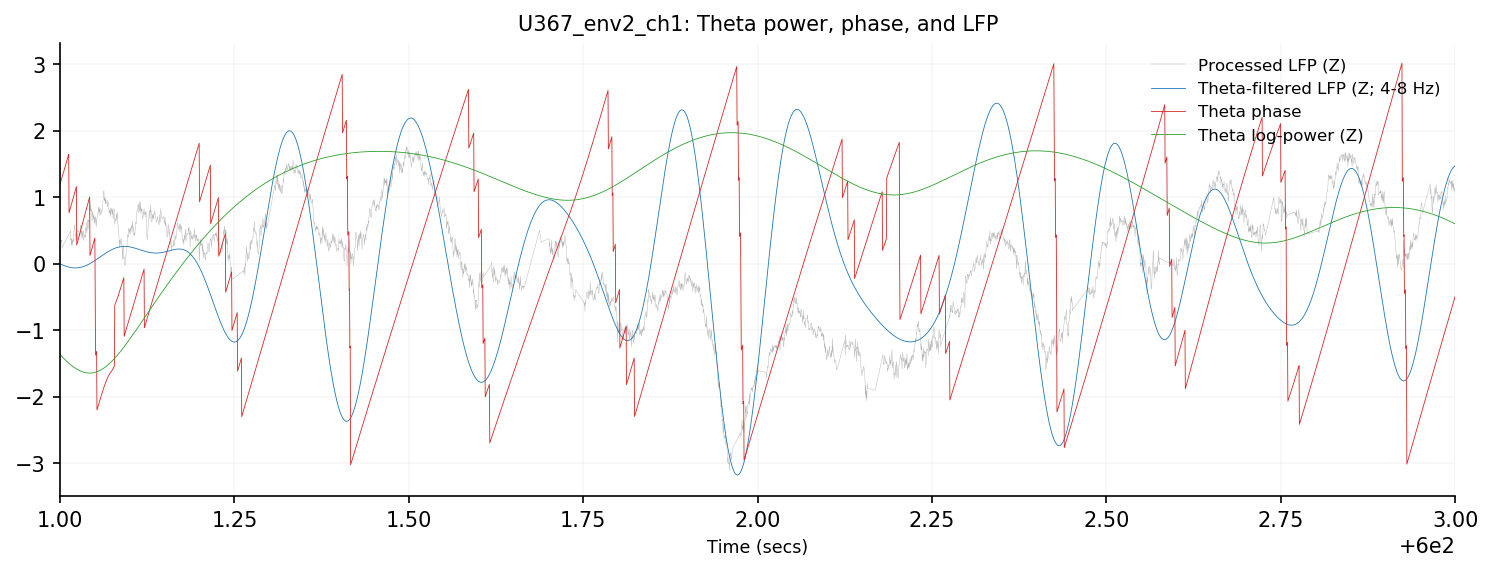

In [154]:
dat = np.vstack((lfp_proc_z.sel(channel='1'), lfp_filt['theta_z'], phase_theta, zlog_power_theta))
fig, ax = plot_trace(dat, 601, duration=2, x_units='secs', linewidths=[0.2, 0.4, 0.4, 0.4], 
                     alphas=[0.6, 1, 1, 1], colors=['C7', 'C0', 'C1', 'C2'],
                     legend_labels=['Processed LFP (Z)', 'Theta-filtered LFP (Z; 4-8 Hz)', 'Theta phase', 'Theta log-power (Z)'],
                     title='{}_ch{}: Theta power, phase, and LFP'.format(subj_sess, chan))

f = os.path.join(figure_dir, 'theta_power_phase_LFP_sanity_check_{}_ch{}.png'.format(subj_sess, chan))
fig.savefig(f)

In [141]:
phase_gamma = np.mean(phase[(phase.frequency>30), :], axis=0)
power_gamma = np.mean(power[(power.frequency>30), :], axis=0)
power_gamma.data = np.log10(power_gamma)
zlog_power_gamma = (power_gamma - power_gamma.mean(dim='time')) / power_gamma.std(dim='time')
del power_gamma

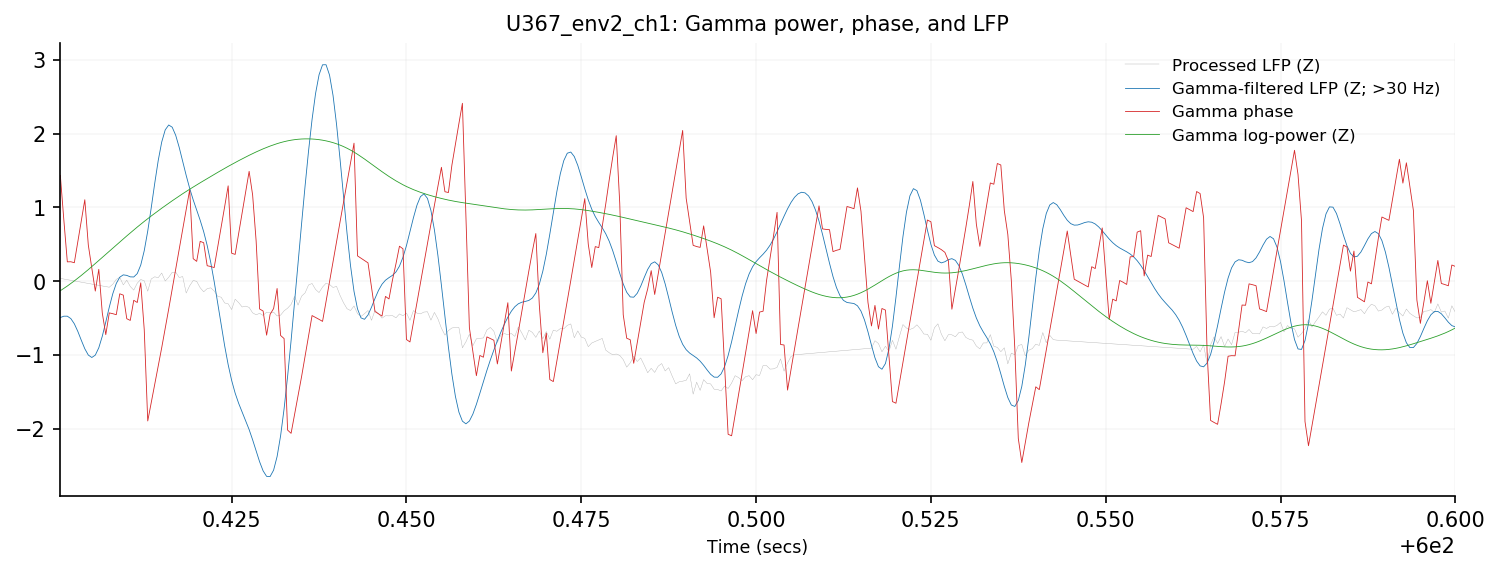

In [155]:
dat = np.vstack((lfp_proc_z.sel(channel='1'), lfp_filt['gamma_z'], phase_gamma, zlog_power_gamma))
fig, ax = plot_trace(dat, 600.4, duration=0.2, x_units='secs', linewidths=[0.2, 0.4, 0.4, 0.4], 
                    alphas=[0.6, 1, 1, 1], colors=['C7', 'C0', 'C1', 'C2'],
                    legend_labels=['Processed LFP (Z)', 'Gamma-filtered LFP (Z; >30 Hz)', 'Gamma phase', 'Gamma log-power (Z)'],
                    title='{}_ch{}: Gamma power, phase, and LFP'.format(subj_sess, chan))

f = os.path.join(figure_dir, 'gamma_power_phase_LFP_sanity_check_{}_ch{}.png'.format(subj_sess, chan))
fig.savefig(f)

In [511]:
epoch_power.freq.data

array([  2.        ,   2.19708228,   2.41358528,   2.65142273,
         2.91269696,   3.19971744,   3.51502125,   3.86139546,
         4.24190178,   4.65990362,   5.11909585,   5.6235374 ,
         6.17768719,   6.78644354,   7.45518744,   8.18983012,
         8.99686534,   9.88342672,  10.85735088,  11.92724663,
        13.10257114,  14.39371346,  15.81208642,  17.37022748,
        19.08190953,  20.96226268,  23.02790799,  25.29710434,
        27.78990989,  30.52835934,  33.53665874,  36.84139939,
        40.47179295,  44.45992965,  48.84106189,  53.65391591,
        58.94103405,  64.74915086,  71.12960612,  78.13879874,
        85.8386852 ,  94.29732727, 103.58949358, 113.79732058,
       125.01103851, 137.329769  , 150.86240127, 165.72855457,
       182.0596356 , 200.        ])

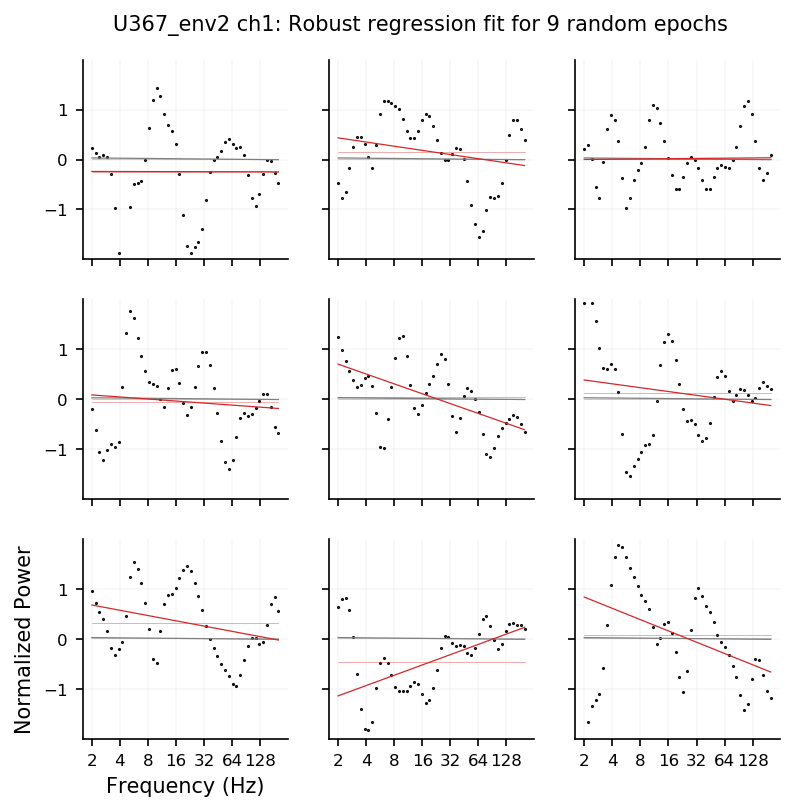

In [539]:
chan = '1'
#epochs = [int(i) for i in np.random.rand(9) * len(epoch_power.epoch)]
dat = wepoch_power.sel(channel=chan, epoch=epochs).data
freqs = wepoch_power.freq.data
_, freq_bands = manning_utils.get_freqs(round(min(freqs), 0), round(max(freqs), 0), len(freqs))

X = sm.add_constant(np.log10(freqs))
mean_intercept = wepoch_band_power.sel(freq='intercept', channel=chan).data.mean()
mean_bband_tilt = wepoch_band_power.sel(freq='bband_tilt', channel=chan).data.mean()
mean_bband_power = wepoch_band_power.sel(freq='bband_power', channel=chan).data.mean()
mean_pred = np.dot(X, [mean_intercept, mean_bband_tilt])

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(6, 6))
ax = ax.ravel()
for i in range(9):
    pred = np.dot(X, wepoch_band_power.sel(channel=chan, epoch=epochs[i]).data[5:7])
    ax[i].plot(np.log10(freqs), dat[i, :], color='k', linewidth=0, marker='.', markersize=1)
    ax[i].plot(np.log10(freqs), mean_pred, color='C7', linewidth=0.6)
    ax[i].plot(np.log10(freqs), np.repeat(np.mean(mean_pred), len(freqs)), 
               color='C7', linewidth=0.3, alpha=0.6)
    ax[i].plot(np.log10(freqs), pred, color='C1', linewidth=0.6)
    ax[i].plot(np.log10(freqs), np.repeat(np.mean(pred), len(freqs)), 
               color='C1', linewidth=0.3, alpha=0.6)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[i].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[i].set_yticks([-1, 0, 1])
    ax[i].set_ylim([-2, 2])
    for item in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        item.set_fontsize(8)
    for item in (ax[i].xaxis.label, ax[i].yaxis.label):
        item.set_fontsize(10)
    if i == 6:
        ax[i].set_xlabel('Frequency (Hz)')
        ax[i].set_ylabel('Normalized Power')
fig.suptitle('{} ch{}: Robust regression fit for 9 random epochs'.format(subj_sess, chan), 
             y=0.93, fontsize=10)

f = os.path.join(figure_dir, 'robust_regression_results_9epochs_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

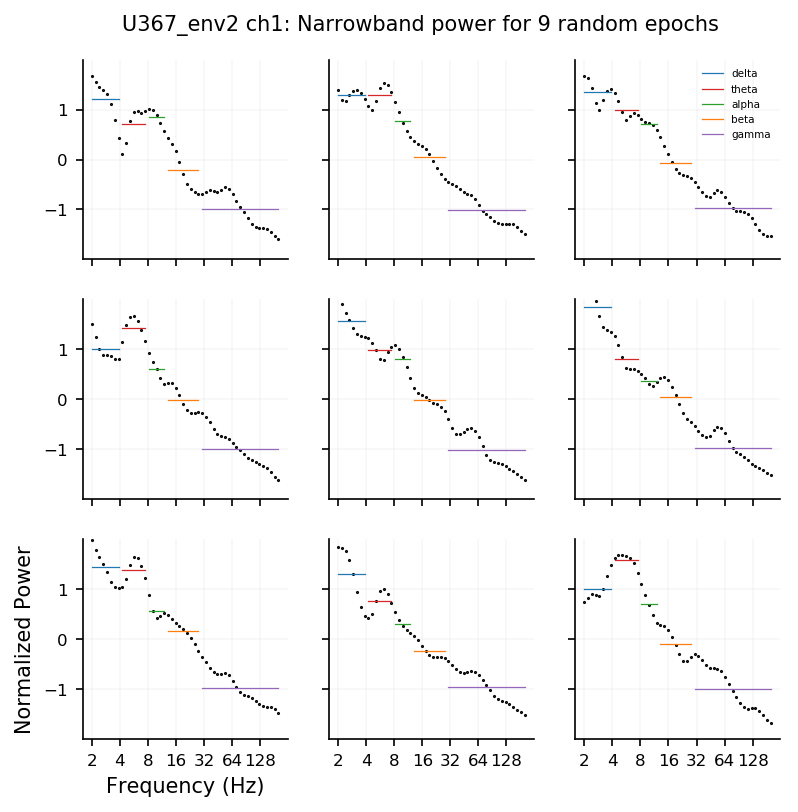

In [540]:
chan = '1'
#epochs = [int(i) for i in np.random.rand(9) * len(epoch_power.epoch)]
dat = epoch_power.sel(channel=chan, epoch=epochs).data
narrowband_xvals = np.array([np.mean(np.log10(freq_bands[i])) for i in freq_bands.keys()])
narrowband_xvals = [np.log10(freq_bands[key]) for key in freq_bands.keys()]

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(6, 6))
ax = ax.ravel()
for i in range(9):
    ax[i].plot(np.log10(freqs), dat[i, :], color='k', linewidth=0, marker='.', markersize=1)
    narrowband_yvals = epoch_band_power.sel(channel=chan, epoch=epochs[i]).data[:5]
    for j in range(5):
        ax[i].plot(narrowband_xvals[j], np.repeat(narrowband_yvals[j], len(narrowband_xvals[j])), 
                   color='C{}'.format(j), linewidth=0.6, label=list(freq_bands.keys())[j])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[i].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[i].set_yticks([-1, 0, 1])
    ax[i].set_ylim([-2, 2])
    for item in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        item.set_fontsize(8)
    for item in (ax[i].xaxis.label, ax[i].yaxis.label):
        item.set_fontsize(10)
    if i == 6:
        ax[i].set_xlabel('Frequency (Hz)')
        ax[i].set_ylabel('Normalized Power')
    if i == 2:
        ax[i].legend(loc=1, prop={'size': 5}, edgecolor='w')
fig.suptitle('{} ch{}: Narrowband power for 9 random epochs'.format(subj_sess, chan), 
             y=0.93, fontsize=10)

f = os.path.join(figure_dir, 'narrowband_power_results_9epochs_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)

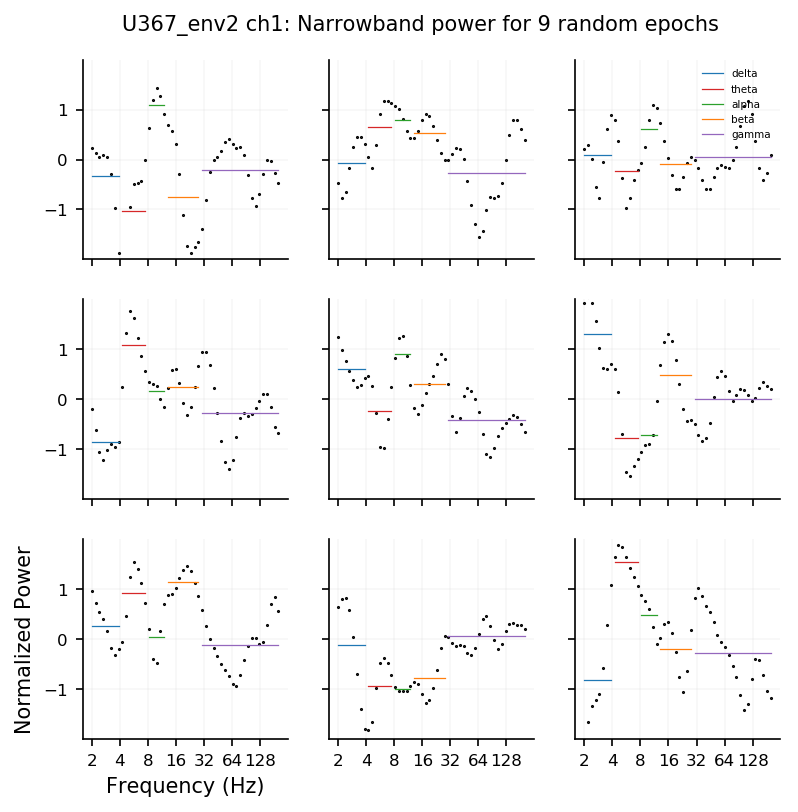

In [541]:
chan = '1'
#epochs = [int(i) for i in np.random.rand(9) * len(epoch_power.epoch)]
dat = wepoch_power.sel(channel=chan, epoch=epochs).data
narrowband_xvals = np.array([np.mean(np.log10(freq_bands[i])) for i in freq_bands.keys()])
narrowband_xvals = [np.log10(freq_bands[key]) for key in freq_bands.keys()]

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(6, 6))
ax = ax.ravel()
for i in range(9):
    ax[i].plot(np.log10(freqs), dat[i, :], color='k', linewidth=0, marker='.', markersize=1)
    narrowband_yvals = wepoch_band_power.sel(channel=chan, epoch=epochs[i]).data[:5]
    for j in range(5):
        ax[i].plot(narrowband_xvals[j], np.repeat(narrowband_yvals[j], len(narrowband_xvals[j])), 
                   color='C{}'.format(j), linewidth=0.6, label=list(freq_bands.keys())[j])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[i].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[i].set_yticks([-1, 0, 1])
    ax[i].set_ylim([-2, 2])
    for item in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        item.set_fontsize(8)
    for item in (ax[i].xaxis.label, ax[i].yaxis.label):
        item.set_fontsize(10)
    if i == 6:
        ax[i].set_xlabel('Frequency (Hz)')
        ax[i].set_ylabel('Normalized Power')
    if i == 2:
        ax[i].legend(loc=1, prop={'size': 5}, edgecolor='w')
fig.suptitle('{} ch{}: Narrowband power for 9 random epochs'.format(subj_sess, chan), 
             y=0.93, fontsize=10)

f = os.path.join(figure_dir, 'narrowband_power_results_9epochs_{}_{}_ch{}.png'.format(subj, sess, chan))
#fig.savefig(f)